<H2 style="text-align: center;">Supervised Machine Learning</H2>
<H2 style="text-align: center;">Predicting Heart Disease Probability</H2>
<H5 style="text-align: center;">Thorsten Brückner, 15/01/23</H5>
<br><br>
<H3 style="text-align: center;">Imports and Definitions</H3>

In [1]:
## BUILT-IN IMPORTS
import warnings
from itertools import combinations
from collections import Counter, defaultdict

## DATA MANIPULATION IMPORTS
import numpy as np
import pandas as pd

## VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

## SKLEARN
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## XGBOOST
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier

## SHAP
import shap

## GLOBAL SETTINGS
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
## VERSIONS
print("VERSIONS:")
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sklearn.__version__)
print("xgboost:", xgb.__version__)
print("shap:", shap.__version__)

VERSIONS:
numpy: 1.23.5
pandas: 1.4.4
seaborn: 0.12.1
sklearn: 1.1.3
xgboost: 1.7.2
shap: 0.41.0


In [1192]:
#### USEFUL FUNCTIONS WRITTEN ON THE WAY

def missing_summary(df):
    
    """ 
    function: 
    summarizes missing values vs total values for each column
    prints only columns with missing values
    parameter: dataframe
    """
    has_non = 0

    for column in df.columns:
        total_values = len(df)
        missing_values = df[column].isnull().sum()
        percentage = ((missing_values/total_values)*100).round(2)

        if missing_values > 0:
            print('df["{}"] - Total values: {}, Missing values: {} ({}%)'.format(column, total_values, missing_values, percentage,))
        else:
            has_non += 1
    
    if has_non == len(df.columns):
        print("Provided dataframe does not have any missing values.")


#############################################################
def get_best_features(data, target_feature, features_to_check, features_to_return,considerration_len = 0.05, min_mean = 0.4):
    
    """
    Parameters:
    data (pd.DataFrame): dataframe to process
    target_feature (str): name of target feature column
    features_to_check (int): number of features to check
    features_to_return (int): number of features to return
    considerration_len (float): minimum consideration length as decimal (default: 0.05)
    min_mean (float): minimum mean as decimal (default: 0.4)
    
    Returns:
    List[str]: list of feature names
    
    This function finds the best combinations of features based on the mean of the target feature and the count of the target feature. 
    Results are filtered by the minimum mean and minimum consideration length. 
    It then returns a list of the top features to return, including the target feature.
    """

    features = [feature for feature in data.columns if feature != target_feature]
    min_to_consider = len(data[data[target_feature] == 1]) * considerration_len
    best_combos = []

    for combo in combinations(features, features_to_check):
        grouped_data = data.groupby(list(combo))
        mean_target = grouped_data[target_feature].mean()
        count_target = grouped_data[target_feature].count()
        filtered_data = mean_target[
            (mean_target > min_mean) & (count_target > min_to_consider)]
        if len(filtered_data) > 1:
            best_combos.append(combo)

    flat_feature_list = [ item for sublist in best_combos for item in sublist ]
    feature_dict = pd.Series(flat_feature_list).value_counts().to_dict()

    new_dict = defaultdict(int)
    for k, v in feature_dict.items():
        base_key = k.split('_')[0]
        new_dict[base_key] = max(new_dict[base_key], v)
    new_dict = { k: v for k, v in feature_dict.items() if v == new_dict[k.split('_')[0]] }
    sorted_clean_features = { k: v for k, v in sorted(new_dict.items(), key = lambda item: item[1], reverse = True) }
    sorted_clean_features = {
        k: v for k, v in sorted_clean_features.items() if Counter(sorted_clean_features.values())[v] == 1 }
    sorted_clean_features

    print(pd.Series(sorted_clean_features)[0:features_to_return])
    feature_list = list(sorted_clean_features.keys())[0:features_to_return]
    feature_list.append(target_feature)
    print(feature_list)

    return feature_list


#############################################################
def check_feature_combo_corrs(data, target_feature, num_of_feat_to_conc, min_desired_correlation = 0.3):

    """
    Parameters:
    data (pd.DataFrame): dataframe to process
    target_feature (str): name of target feature column
    num_of_feat_to_conc (int): number of features to combine
    min_desired_correlation (float): minimum correlation desired as decimal (default: 0.3)
    
    Returns:
    dict: dictionary of best feature combinations and their correlation values

    This function finds the best combinations of features based on the correlation with the target feature, filtered by the minimum desired correlation. 
    It then returns a dictionary of the top feature combinations and their correlation values with the target feature
    """

    temp_data = data.copy(deep = True) 
    features = [feature for feature in temp_data.columns if feature != target_feature]
    combos = combinations(features, num_of_feat_to_conc)
    best_combos_ = {}

    for combo in combos:
        col1, col2, *other_cols = combo

        temp_data["Combo_feature"] = temp_data[col1].astype(str) + '_' + temp_data[col2].astype(str)
        for col in other_cols:
            temp_data["Combo_feature"] += '_' + temp_data[col].astype(str)
        temp_data["Combo_feature"] = temp_data["Combo_feature"].astype("category")
        temp_data["Combo_feature"] = temp_data["Combo_feature"].cat.codes
        corr = temp_data["Combo_feature"].corr(temp_data[target_feature])
        
        if corr > min_desired_correlation:
            # Print the correlation and the combination of columns used
            print(f"Correlation for {combo}: {corr}")
            best_combos_[combo] = corr
        
    best_combos_ = dict(sorted(
        best_combos_.items(), 
        key = lambda item: item[1], 
        reverse = True))
    
    return best_combos_


#############################################################
def engineer_features(data, list_of_dicts):

    """
    Parameters:
    data (pd.DataFrame): dataframe to process
    list_of_dicts (list): list of dictionaries containing feature combinations

    Returns:
    pd.DataFrame: dataframe with engineered features
    
    This function takes in a dataframe and a list of dictionaries containing feature combinations. 
    It then creates new features by combining the specified features and adding them to the dataframe. 
    It returns the modified dataframe.
    """

    temp_df = data.copy(deep = True)
    for dic in list_of_dicts:
        for features in dic.keys():
            feat1, feat2, *other_feats = features
            name = feat1[:8] + "_" + feat2[:8] 
            for feat in other_feats:
                name += "_" + feat[:8]
            temp_df[name] = temp_df[feat1].astype(str) + '_' + temp_df[feat2].astype(str)
            for feat in other_feats:
                temp_df[name] += '_' + temp_df[feat].astype(str)
            temp_df[name] = temp_df[name].astype("category")
            temp_df[name] = temp_df[name].cat.codes
    return temp_df
    

#############################################################
### model functions // my pipeline
def master_modeller(df, target_name, model_dict):
    """
    Parameters:
    df (pd.DataFrame): dataframe to process
    target_name (str): name of target feature column
    model_dict (dict): dictionary containing model instances and their corresponding parameter grids
    
    Returns:
    Tuple: containing train, test data and dictionary of trained models.
    
    This function splits the data into training and test sets, performs grid search cross validation on the models, and fits the models on the training data.
    It then evaluates the models on the test data and prints the evaluation metrics and ROC curve.
    """

    data_target = df[target_name]
    data = df.drop([target_name], axis = 1)
    train, test, target, target_test = train_test_split(
        data, 
        data_target, 
        test_size = 0.3, 
        random_state = 44)

    def grid_searcher(model, params):
        grid_search = GridSearchCV(
        estimator = model, 
        param_grid = params, 
        cv = 2, n_jobs = 12, verbose = 0, 
        scoring = "recall")

        grid_search.fit(train, target)
        model_best = grid_search.best_estimator_
        return model_best
    
    def run_and_fit_models(model_dict):
        model_storage = {}
        for algo in model_dict.keys():
            model_name = algo
            model = model_dict[algo]["model"]
            params = model_dict[algo]["params"]

            model_best = grid_searcher(model, params)
            model_best.fit(train, target)
            model_storage[model_name] = model_best
        return model_storage

    def evaluate_models(stored_models):
        plt.clf()
        for model in stored_models.keys():
            model_name = model
            model_instance = stored_models[model]

            pred_train = model_instance.predict(train)
            confusion_matrix_train = metrics.confusion_matrix(target, pred_train)
            Accuracy_train = metrics.accuracy_score(target, pred_train)
            Precision_train = metrics.precision_score(target, pred_train)
            Recall_train = metrics.recall_score(target, pred_train)
            F_1_Score_train = metrics.f1_score(target, pred_train)

            pred = model_instance.predict(test)
            confusion_matrix = metrics.confusion_matrix(target_test, pred)
            Accuracy = metrics.accuracy_score(target_test, pred)
            Precision = metrics.precision_score(target_test, pred)
            Recall = metrics.recall_score(target_test, pred)
            F_1_Score = metrics.f1_score(target_test, pred)

            tn, fp, fn, tp = confusion_matrix.ravel()
            probs = model_instance.predict_proba(test)
            probs = probs[:, 1]
            fpr, tpr, thresholds = roc_curve(target_test, probs)
            auc_score = roc_auc_score(target_test, probs)

            print("\nScorings for ", model_name)
            print("Train: ", Accuracy_train, Precision_train, Recall_train)
            print("Test: ", Accuracy, Precision, Recall)
            print(f"TN = {tn} - FN = {fn} - TP = {tp} - FP = {fp}")
            print("AUC score:", auc_score, " mean probabilities:", probs.mean())  
            plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))

        plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(loc = "lower right")
        plt.title("ROC curve")
        plt.show()

    stored_models = run_and_fit_models(model_dict)
    evaluate_models(stored_models)

    return train, test, stored_models


#############################################################
## One-Hot-Encoding
def generate_dummies(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix = column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis = 1)
    return dataframe.drop(column_name, axis = 1)

    
#############################################################
def CMT_maker(feature):
    name = feature
    sums = df.groupby(feature).sum()[TARGET]
    counts = df[feature].value_counts()
    means = sums / counts
    overall_mean = df[TARGET].mean()
    encoded = (means * counts + overall_mean * (df.shape[0] - counts)) / df.shape[0] * 100
    df[feature + "_CMT"] = df[feature].map(encoded).round(3)


#############################################################
def feature_vs_target_w_lengh(feature):
    sleep_pivot = df.pivot_table(
        index = [feature], values = TARGET,
        aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

    fig, ax = plt.subplots()
    scatter = ax.scatter(
        sleep_pivot.index, sleep_pivot[("mean", TARGET)], c = sleep_pivot[("len", TARGET)], 
        cmap = "viridis", alpha = 0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel("Heart Disease Rate")
    ax.set_title(feature + " vs Heart Disease Rate")
    cbar = fig.colorbar(scatter)
    cbar.set_label("len")
    plt.show()


#############################################################
## my 5 minutes of extreme sillyness
def print_formatted_word(word):
    total_length = len("####################  SCORES & EVALUATIONS  #############################")
    word_length = len(word)
    num_of_hashes_before = len("####################  ")
    num_of_hashes_after = total_length - (num_of_hashes_before + word_length)
    print("#" * num_of_hashes_before + " " + word + " " + "#" * num_of_hashes_after)

In [1193]:
## data imports
df = pd.read_csv("heart_disease_data.csv")
df.name = "Base DF"
data_dict = pd.read_csv("data_dictionary.csv", delimiter = ";")
data_dict.drop("Unnamed: 2", axis = 1, inplace = True)

In [1194]:
## DEFINITIONS
TARGET = "HeartDisease"
RANDOM_STATE = 55

<br>
<br>
<H1 style="text-align: center;">Predicting the risk of heart disease</H1>

<p>Our assignment is to implement a machine learning model to predict the probability of a person having heart disease. In order to complete this task, we will be following the stages of the ML Checklist, including data understanding, data preparation, modeling, and evaluation. We will be organizing and commenting our code to ensure it is easy to understand and runs without errors. Additionally, we will be exploring different algorithms to find the best possible solution for the problem.</p><br>
<br>

<H2 style="text-align: center;">Data Understanding</H2>
<H3 style="text-align: center;">Univariate Data Analysis</H3>
<p>To gain a deeper understanding of our dataset, we will begin by conducting a univariate analysis. This will include examination of the size and structure of the data, an overview of the variable types and their descriptive statistics, identification of any missing values, and an exploration of the distribution of the data.</p><br>
<br>

<span style=font-weight:bold;font-size:23px;>
    Glossary
<span>

<b>HeartDisease:</b>  
Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)  
<b>BMI:</b>  
Body Mass Index (BMI)  
<b>Smoking:</b>  
Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]  
<b>AlcoholDrinking:</b>   
Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week  
<b>Stroke:</b>  
(Ever told) (you had) a stroke?  
<b>PhysicalHealth:</b>  
Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days)  
<b>MentalHealth:</b>  
Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days)  
<b>DiffWalking:</b>   
Do you have serious difficulty walking or climbing stairs?  
<b>Sex:</b>  
Are you male or female?  
<b>AgeCategory:</b>  
Fourteen-level age category  
<b>Race:</b>  
Imputed race/ethnicity value  
<b>Diabetic:</b>  
(Ever told) (you had) diabetes?  
<b>PhysicalActivity:</b>  
Adults who reported doing physical activity or exercise during the past 30 days other than their regular job  
<b>GenHealth:</b>  
Would you say that in general your health is Good/Very Good/…  
<b>SleepTime:</b>  
On average, how many hours of sleep do you get in a 24-hour period?  
<b>Asthma:</b>  
(Ever told) (you had) asthma?  
<b>KidneyDisease:</b>  
Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?  
<b>SkinCancer:</b>   
(Ever told) (you had) skin cancer?  
<b>HeartDisease_FamilyHistory:</b>  
Do you have family history of heart disease?   
<b>State:</b>  
US sate (residency) <br>
<br>
<br>

In [1195]:
## Dataframe shape

df.shape

(319795, 20)

In [1196]:
## First look

df.head().T

,0,1,2,3,4
HeartDisease,No,No,No,No,No
BMI,16.6,20.34,26.58,24.21,23.71
Smoking,Yes,No,Yes,No,No
AlcoholDrinking,No,NaN,NaN,NaN,No
Stroke,No,Yes,No,No,No
PhysicalHealth,3.0,0.0,20.0,0.0,28.0
MentalHealth,30.0,0.0,30.0,0.0,0.0
DiffWalking,No,No,No,No,Yes
Sex,Female,Female,Male,Female,Female
AgeCategory,55-59,80 or older,65-69,75-79,40-44


In [1197]:
## Data types

df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HeartDisease                319795 non-null  object 
 1   BMI                         319795 non-null  float64
 2   Smoking                     319795 non-null  object 
 3   AlcoholDrinking             212984 non-null  object 
 4   Stroke                      318683 non-null  object 
 5   PhysicalHealth              319795 non-null  float64
 6   MentalHealth                319795 non-null  float64
 7   DiffWalking                 319795 non-null  object 
 8   Sex                         319795 non-null  object 
 9   AgeCategory                 319795 non-null  object 
 10  Race                        319795 non-null  object 
 11  Diabetic                    319795 non-null  object 
 12  PhysicalActivity            319795 non-null  object 
 13  GenHealth     

In [1198]:
## First descriptive statistics
## Numericals

df.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.327367,6.369381,12.02,24.03,27.34,31.44,119.0
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.0
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.0
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.0


In [1199]:
## First descriptive statistics
## Categoricals

df.describe(include = ["object"]).T

,count,unique,top,freq
HeartDisease,319795,2,No,292422
Smoking,319795,2,No,187887
AlcoholDrinking,212984,2,No,191207
Stroke,318683,2,No,306614
DiffWalking,319795,2,No,275385
Sex,319795,2,Female,167805
AgeCategory,319795,14,65-69,34143
Race,319795,6,White,245212
Diabetic,319795,4,No,269653
PhysicalActivity,319795,2,Yes,247957


In [1200]:
## Duplicated values

df.duplicated().value_counts()

False    319541
True        254
dtype: int64

In [1201]:
## Null values

missing_summary(df)

df["AlcoholDrinking"] - Total values: 319795, Missing values: 106811 (33.4%)
df["Stroke"] - Total values: 319795, Missing values: 1112 (0.35%)
df["SkinCancer"] - Total values: 319795, Missing values: 349 (0.11%)
df["HeartDisease_FamilyHistory"] - Total values: 319795, Missing values: 284532 (88.97%)


<br>
<br>
<br>

<H3 style="text-align: center;">Multivariate Analysis, Data Cleaning, Transformation and Pre-Processing
</H3>
<p>In this section, we will be undertaking a comprehensive multivariate analysis of our data, including data cleaning, transformation, and pre-processing. Our goal is to prepare the data for modeling in the most effective way possible.<br>
<br>
We will investigate the distribution of variables, identify and analyze correlations between variables and our target, address any outliers present in the data, and use visualization techniques to effectively present our findings where appropriate. In order to keep this notebook clear and easy to read, we will not delve into every single detail, experiment, and iteration of our efforts. Instead, we will focus on providing a comprehensive overview of the process, combining steps where appropriate.</p>

<br><br><H5 style="text-align: center;">TARGET: HeartDisease</H5>
<p>The "HeartDisease" feature indicates if a patient has a history of coronary heart disease or myocardial infarction. To simplify our analysis, we will convert the target feature into a boolean format. As a first step, we will display it's distribution.</p>

In [1202]:
df[TARGET] = LabelEncoder().fit_transform(df[TARGET])
print(df[TARGET].value_counts(normalize = True), "\n")
print(f"Heart Disease Rate: {round(df[TARGET].mean(), 3) * 100}%")

0    0.914405
1    0.085595
Name: HeartDisease, dtype: float64 

Heart Disease Rate: 8.6%


<br>
<H5 style="text-align: center;">AlcoholDrinking</H5>
<p>The "AlcoholDrinking" feature determines whether a patient is a heavy drinker or not. The feature has a high percentage of missing values and is in string format. To facilitate visualization and analysis, we will convert the feature into numerical format. However, after further examination, we have determined that the high percentage of missing values and lack of significant correlation with the target variable warrant dropping this feature from our dataset.</p>

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
AlcoholDrinking,,,
0,191207,16864,0.088198
1,21777,1141,0.052395
2,106811,9368,0.087706


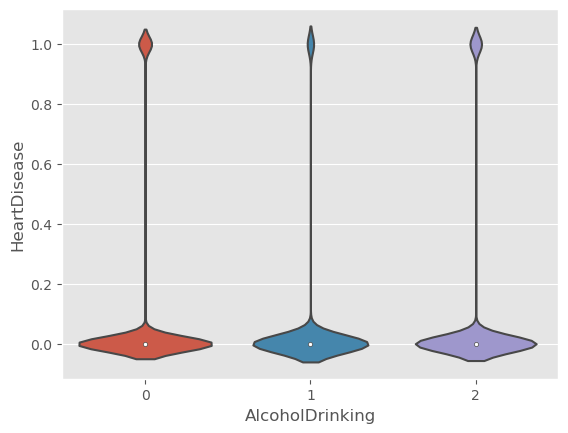

In [1203]:
df["AlcoholDrinking"] = LabelEncoder().fit_transform(df["AlcoholDrinking"])

sns.violinplot(data = df, x = "AlcoholDrinking", y = TARGET)

df.pivot_table(
    index = "AlcoholDrinking", values = [TARGET],
    aggfunc = [len, sum, np.mean])

In [1204]:
df.drop("AlcoholDrinking", axis = 1, inplace = True)

<br>
<H5 style="text-align: center;">Stroke</H5>
<p>The "Stroke" feature aims to determine if a patient has ever been diagnosed or experienced a stroke. To ensure the integrity of our data, we will be filling in any missing values with "No" and subsequently converting the feature into a numerical binary format where 1 represents a "Yes" response and 0 represents a "No" response. Our assumption is that patients who did not provide an answer did not have a stroke, as the missing values have been found to have the same mean to target as the "No" responses.<br>
<br>
<u>Conclusion:</u> Patients with a history of stroke appear to have a significantly increased risk for heart disease.</p>

In [1205]:
print(df["Stroke"].value_counts(), "\n")
print("Yes:", df[df["Stroke"] == "Yes"][TARGET].mean())
print("No:", df[df["Stroke"] == "No"][TARGET].mean())
print("NaN:", df[df["Stroke"].isna()][TARGET].mean())

df["Stroke"].fillna("No", inplace = True)
df["Stroke"] = df["Stroke"].map(lambda x: 1 if x == "Yes" else 0)

No     306614
Yes     12069
Name: Stroke, dtype: int64 

Yes: 0.3636589609743972
No: 0.07470630825728766
NaN: 0.07014388489208633


<br>
<H5 style="text-align: center;">SkinCancer</H5>
<p>The "SkinCancer" feature tells us if a patient has ever had or been diagnosed with skin cancer. We are handling the "SkinCancer" feature by replacing missing values with "No" and converting it to numerical binary format (1 for "Yes", 0 for "No"). This is based on the assumption that missing values indicate the patient does not have skin cancer, as those have the same mean to target as "No" responses.<br>
<br>
<u>Conclusion:</u> Patients with a history of skin cancer appear to have a increased risk for heart disease.</p>

In [1206]:
print(df["SkinCancer"].value_counts(), "\n")
print("Yes:", df[df["SkinCancer"] == "Yes"][TARGET].mean())
print("No:", df[df["SkinCancer"] == "No"][TARGET].mean())
print("NaN:", df[df["SkinCancer"].isna()][TARGET].mean())

df["SkinCancer"].fillna("No", inplace = True)
df["SkinCancer"] = df["SkinCancer"].map(lambda x: 1 if x == "Yes" else 0)

No     289627
Yes     29819
Name: SkinCancer, dtype: int64 

Yes: 0.16700761259599584
No: 0.07720619969823256
NaN: 0.09169054441260745


<br>
<H5 style="text-align: center;">HeartDisease_FamilyHistory</H5>
<p>The "HeartDisease_FamilyHistory" feature describes whether or not a patient's family has a history of heart disease. The feature has 88.97% missing values and upon further examination, we have determined that the mean to the target is the same for "Yes", "No" and "NaN" responses. Additionally, the number of "Yes" responses is very low overall. We have decided to drop this feature from our dataset as the high percentage of missing values and the lack of a clear correlation with the target variable make it unreliable for further analysis.</p>

Yes: 0.08878648233486944
No: 0.08272931767058235
NaN: 0.08588137713859953
Overall correlation to target: 0.003197


,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
HeartDisease_FamilyHistory,,,
No,32008,2648,0.082729
Yes,3255,289,0.088786
NaN,284532,24436,0.085881


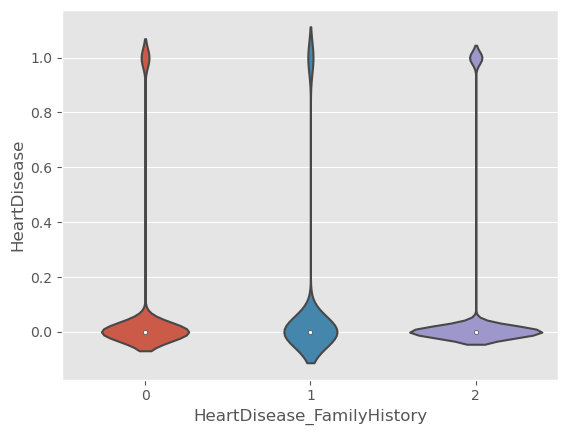

In [1207]:
df["HeartDisease_FamilyHistory"] = LabelEncoder().fit_transform(
    df["HeartDisease_FamilyHistory"])

sns.violinplot(
    data = df,
    x = "HeartDisease_FamilyHistory", y = TARGET)

print("Yes:", df[df["HeartDisease_FamilyHistory"] == 1][TARGET].mean())
print("No:", df[df["HeartDisease_FamilyHistory"] == 0][TARGET].mean())
print("NaN:", df[df["HeartDisease_FamilyHistory"] == 2][TARGET].mean())
print("Overall correlation to target:", round(df[["HeartDisease_FamilyHistory", TARGET]].corr().iloc[1:2, 0:1]["HeartDisease_FamilyHistory"][0] ,6))

fam_hist = df.pivot_table(
    index = ["HeartDisease_FamilyHistory"], values = TARGET,
    aggfunc = [len, sum, np.mean])
fam_hist.rename(index = {0: "No", 1: "Yes", 2: "NaN"})

In [1208]:
df.drop("HeartDisease_FamilyHistory", inplace = True, axis = 1)

<br>
<H5 style="text-align: center;">Smoking, Asthma, KidneyDisease and DiffWalking</H5>
<p>The "Smoking", "Asthma", "KidneyDisease" and "DiffWalking" features indicate if a patient has a history of smoking, asthma diagnosis, kidney disease and/or difficulties walking respectively.</p><br>
<p>The 4 features are currently in string format with "Yes" and "No" values. In order to facilitate further analysis, we will convert these features into a binary format. However, it's worth noting that at this stage, no further transformation or analysis is required. We will later evaluate the usefulness of these features and decide whether or not to retain them in our final dataset.<br>
<br>
<u>Conclusion:</u> When considering the risk factors for heart disease, it is evident that patients who answer "Yes" to these questions have an increased likelihood of developing the condition. By analyzing the impact of these factors, we can rank them in descending order of potential influence: Kidney Disease, Difficulty of Walking, Smoking, and Asthma.</p>

In [1209]:
## Looping through the features, transforming from string to binary numerical and creating a nicely readable summary pivot table

pivot_print = pd.DataFrame()
for feature in ["Smoking", "Asthma", "KidneyDisease", "DiffWalking"]:

    df[feature] = df[feature].map(lambda x: 1 if x == "Yes" else 0)

    pivot_smoke = df.pivot_table(index = [feature], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)
    pivot_smoke.rename(index = {0: f"{feature} No", 1: f"{feature} Yes"}, inplace = True)
    
    pivot_print = pd.concat([pivot_print, pivot_smoke], axis = 0)
pivot_print

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Smoking Yes,131908,16037,0.121577
Smoking No,187887,11336,0.060334
Asthma Yes,42872,4933,0.115063
Asthma No,276923,22440,0.081033
KidneyDisease Yes,11779,3455,0.293319
KidneyDisease No,308016,23918,0.077652
DiffWalking Yes,44410,10028,0.225805
DiffWalking No,275385,17345,0.062985


<br>
<H5 style="text-align: center;">Sex</H5>
<p>The "Sex" feature indicates the gender of the patient. We will rename it to "IsMale" and convert it from a string format to a binary numerical format for ease of analysis.<br>
<br>
<u>Conclusion:</u> Male patients tend to have a higher likelyhood to have a heart disease.</p>

In [1210]:
df = df.rename(columns = { "Sex": "IsMale" })
df["IsMale"] = df["IsMale"].map(lambda x: 1 if x == "Male" else 0)

df.pivot_table(
    index = ["IsMale"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
IsMale,,,
1,151990,16139,0.106185
0,167805,11234,0.066947


<br>
<H5 style="text-align: center;">PhysicalActivity</H5>
<p>The "PhysicalActivity" feature indicates if a patient is physically active or not. In order to align it with other boolean/binary numerical features, we will rename it to "NoPhysActivity" and remap the values, where "No" is mapped to 1 and "Yes" to 0. This will ensure that the higher value is always weighted towards a positive target, making it easier to analyze.<br>
<br>
<u>Conclusion:</u> The lack of physical activity shows to be a risk factor for heart disease.</p>

In [1211]:
df = df.rename(columns = { "PhysicalActivity": "NoPhysActivity" })
df["NoPhysActivity"] = df["NoPhysActivity"].map(lambda x: 1 if x == "No" else 0)

df.pivot_table(
    index = ["NoPhysActivity"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
NoPhysActivity,,,
1,71838,9884,0.137587
0,247957,17489,0.070532


<br>
<p>A quick examination of the correlation of our binary numerical features with the target reveals that "Yes" responses tend to have a higher mean to target than "No" responses. Of these features, Stroke, DiffWalking and KidneyDisease appear to have the strongest correlation with the target.</p>

In [1212]:
df[[TARGET, "Stroke", "SkinCancer", "Smoking", "Asthma", "KidneyDisease", "DiffWalking", "IsMale", "NoPhysActivity"]].corr()[0:1].T.style.background_gradient(axis = None)

,HeartDisease
HeartDisease,1.000000
Stroke,0.196835
SkinCancer,0.093317
Smoking,0.107764
Asthma,0.041444
KidneyDisease,0.145197
DiffWalking,0.201258
IsMale,0.070040
NoPhysActivity,0.100030


<br>
<H5 style="text-align: center;">Diabetic</H5>
<p>The "Diabetic" feature indicates if a patient has ever been diagnosed with diabetes. The feature is in string format and contains "Yes", "No", "Borderline Diabetes" and "Yes, during pregnancy" as possible responses. People with borderline diabetes and women who were diabetic during pregnancy have a generally higher risk of developing diabetes.<br>
<br>
To better analyze this feature, we will re-categorize it into three groups: "Yes", "No", and "HighRisk", where "HighRisk" will be a summary of the "Borderline Diabetes" and "Yes, during pregnancy" responses. Then, we will create three new features based on these three categorical values to further analyze the relationship between diabetes and other variables.<br>
<br>
<u>Conclusion:</u> Our analysis reveals that individuals with diabetes have a significantly increased risk of developing heart disease.</p>

In [1213]:
df["Diabetic"].value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

In [1214]:
dia_dict = { 
    "Yes": "Yes", 
    "No": "No", 
    "No, borderline diabetes": "RiskHigh",
    "Yes (during pregnancy)": "RiskHigh"}
df["Diabetic"] = df["Diabetic"].map(dia_dict)

df.pivot_table(
    index = ["Diabetic"], values = TARGET,
    aggfunc = [len, sum, np.mean])

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Diabetic,,,
No,269653,17519,0.064969
RiskHigh,9340,897,0.096039
Yes,40802,8957,0.219524


In [1215]:
df.rename(columns = {"Diabetic": "Diab"}, inplace = True)
df = generate_dummies(df, "Diab")

<br>
<H5 style="text-align: center;">BMI</H5>
<p>The "BMI" feature contains values from 12 to 119, which initially may seem unrealistic, but after researching official data from the US Centers for Disease Control and Prevention, we have learned that over 40% of US citizens are overweight and around 1% of the population reaches weight levels of 200 kg and more. Given this, even a BMI of 119 is possible. Our dataset contains about 1% of people classified as Obese III and beyond (BMI 50+) and about 0.01% above BMI 80. We will assume the data is correct.<br>
<br>
To analyze the BMI feature, we will categorize the values into a regular BMI table from Severe Underweight to Obese 3, using numerical values as category labels. Additionally, we will perform a logarithmic transformation on the original feature. We will keep all three features (original, categorized and logarithmically transformed) in the dataset for now, and will decide which one to keep later.<br>
<br>
<u>Conclusion</u>: 
We can observe that having a normal BMI (between 19 and 24) does not appear to have a significant impact on the likelihood of developing Heart Disease. However, being outside the norm, particularly in the case of high Obese III and severe underweight values, tends to increase the mean to target.
</p>

In [1216]:
df["BMI"].describe()

count    319795.000000
mean         28.327367
std           6.369381
min          12.020000
25%          24.030000
50%          27.340000
75%          31.440000
max         119.000000
Name: BMI, dtype: float64

Above BMI 50: 0.788 %
Above BMI 80: 0.013 %


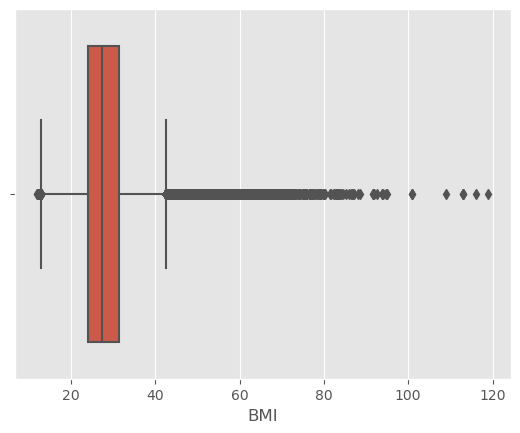

In [1217]:
sns.boxplot(data = df, x = "BMI")

print("Above BMI 50:", round(len(df[df["BMI"] > 50]) / len(df) * 100, 3), "%")
print("Above BMI 80:", round(len(df[df["BMI"] > 80]) / len(df) * 100, 3), "%")

In [1218]:
df["BMI_orig"] = df["BMI"]
df.drop("BMI", inplace = True, axis = 1)

## Creating and applying target mean per value score
bmi_dict = {
    10.1: (0, 16),
    7.5: (16.01, 18.5),
    5.9: (18.51, 22.5),    
    7.0: (22.51, 24.99),    
    8.0: (25, 26.66),
    9.0: (26.67, 28.33),
    9.5: (28.34, 29.99),
    10.0: (30, 34.99),
    8.8: (35, 200)}
df["BMI_grped"] = df["BMI_orig"].apply(
    lambda x: next((cat for cat, range in bmi_dict.items() if range[0] <= x <= range[1])))

## Logarithmic transformation
df["BMI_LN"] = df["BMI_orig"].apply(lambda x: np.log1p(x))

pivot_bmi = df.pivot_table(
    index = ["BMI_grped"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)
pivot_bmi

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
BMI_grped,,,
8.8,41503,4513,0.108739
10.1,692,72,0.104046
10.0,61342,6159,0.100404
9.5,32124,3059,0.095225
9.0,35454,3138,0.088509
8.0,46932,3794,0.080840
7.5,4422,329,0.074401
7.0,52828,3682,0.069698


<p>We were somewhat surprised to find that the overall correlation to the target is relatively low for all variations of the feature.</p>

In [1219]:
df[["BMI_orig", "BMI_grped", "BMI_LN", TARGET]].corr().style.background_gradient(axis = None)

,BMI_orig,BMI_grped,BMI_LN,HeartDisease
BMI_orig,1.000000,0.648399,0.985754,0.051746
BMI_grped,0.648399,1.000000,0.722851,0.052981
BMI_LN,0.985754,0.722851,1.000000,0.053940
HeartDisease,0.051746,0.052981,0.053940,1.000000


<br>
<H5 style="text-align: center;">PhysicalHealth, MentalHealth</H5>
<p>The "PhysicalHealth" and "MentalHealth" features describe, on a scale of 0-30, the number of days a patient has felt physically or mentally unwell recently. To analyze this feature, we will employ multiple strategies:<br>
<br>

- We will convert the features into a binary numerical format, 0 for 0 to 3 days and 1 for 4 to 30 days for PhysicalHealth and 1 for 0-27 and 0 for 28-30 for MentalHealth. We chose these ranges as the mean to target per value indicates that all numbers above 3 have an effect on the heart disease rate.<br>
- We will convert the features into a numerical format, using the cardinality and mean to target. We will do this, as the vast majority of patients responded with 0.<br>
- We will perform a logarithmic transformation on the features.  <br>
<br>

<u>Conclusion</u>: 
Based on our analysis, it appears that the "PhysicalHealth" feature has a significant correlation with the target, while the "MentalHealth" feature does not show a strong correlation.<br>
</p>

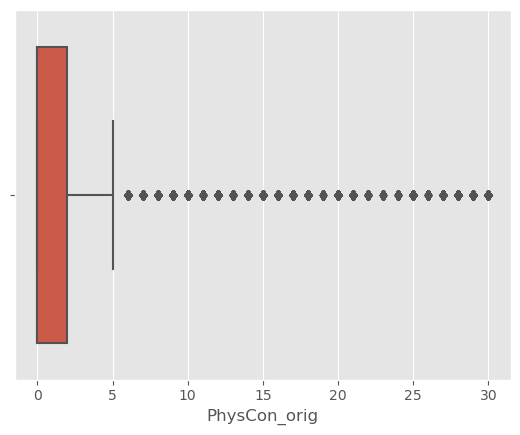

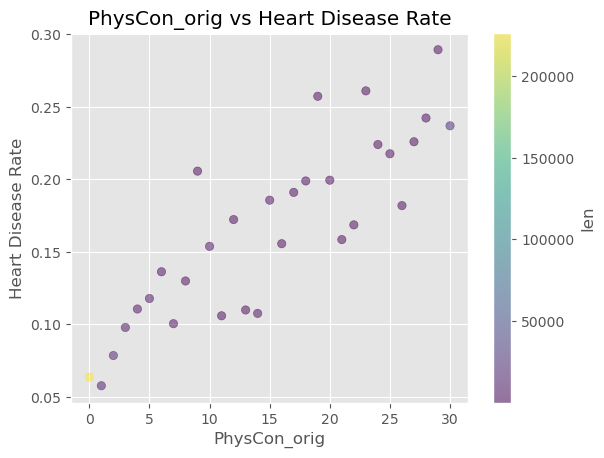

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
PhysCon_orig,,,
30.0,19507,4619,0.236787
25.0,1163,253,0.217541
21.0,625,99,0.158400
20.0,3216,641,0.199316
15.0,5012,930,0.185555
14.0,2892,311,0.107538
12.0,604,104,0.172185
10.0,5451,838,0.153733


In [1270]:

df = df.rename(columns = { "PhysicalHealth": "PhysCon_orig" })
sns.boxplot(data = df, x = "PhysCon_orig")
feature_vs_target_w_lengh("PhysCon_orig")

pivot_df = df.pivot_table(
    index = ["PhysCon_orig"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)
pivot_df[pivot_df["len", TARGET] > 500]

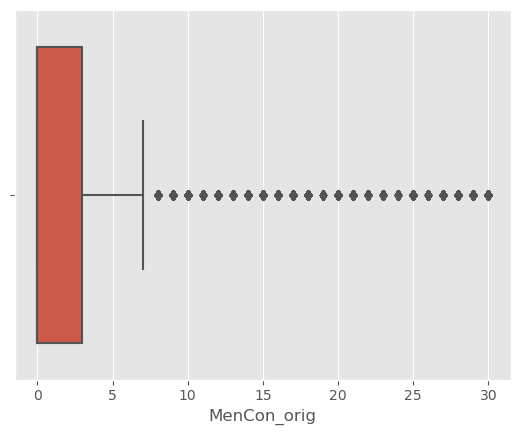

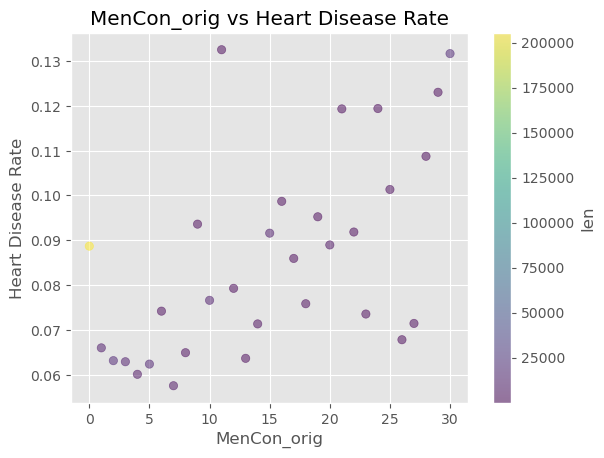

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
MenCon_orig,,,
30.0,17370,2287,0.131664
28.0,515,56,0.108738
25.0,1954,198,0.101331
20.0,5430,483,0.088950
15.0,9893,906,0.091580
14.0,2047,146,0.071324
12.0,757,60,0.079260
10.0,10511,805,0.076586


In [1272]:
df = df.rename(columns = { "MentalHealth": "MenCon_orig" })
sns.boxplot(data = df, x = "MenCon_orig")
feature_vs_target_w_lengh("MenCon_orig")


pivot_df = df.pivot_table(
    index = ["MenCon_orig"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)
pivot_df[pivot_df["len", TARGET] > 500]

In [1274]:
## Creating and applying a cardinality vs mean score
CMT_maker("PhysCon_orig")

df.pivot_table(
    index = ["PhysCon_orig_CMT"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
PhysCon_orig_CMT,,,
9.482,19507,4619,0.236787
8.716,5012,930,0.185555
8.676,5451,838,0.153733
8.674,3216,641,0.199316
8.636,7606,896,0.117802
8.608,1163,253,0.217541
8.594,4468,494,0.110564
8.593,8616,843,0.097841


In [1225]:
## Logarithmic transformation
df["PhysCon_LN"] = df["PhysCon_orig"].apply(lambda x: np.log1p(x))

pivot_df = df.pivot_table(
    index = ["PhysCon_LN"],
    values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)
pivot_df[pivot_df["len", TARGET] > 500]

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
PhysCon_LN,,,
3.433987,19509,4619,0.236763
3.258097,1164,254,0.218213
3.091042,626,99,0.158147
3.044522,3216,641,0.199316
2.772589,5012,930,0.185555
2.708050,2893,312,0.107847
2.564949,605,104,0.171901
2.397895,5453,838,0.153677


In [1226]:
df["MenCon_LN"] = df["MenCon_orig"].apply(lambda x: np.log1p(x))
pivot_df = df.pivot_table(
    index = ["MenCon_LN"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending = False)
pivot_df[pivot_df["len", TARGET] > 1000]

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
MenCon_LN,,,
3.433987,17373,2287,0.131641
3.258097,1954,198,0.101331
3.044522,5431,483,0.088934
2.772589,9896,907,0.091653
2.708050,2048,147,0.071777
2.397895,10513,805,0.076572
2.197225,1094,71,0.064899
2.079442,5528,318,0.057525


In [1227]:
## Creating bineary categories, based on selected threshold ranges.
phys_dict = { 0: (0, 3), 1: (3.1, 200)}
df["PhysCon_bin"] = df["PhysCon_orig"].apply(
    lambda x: next((cat for cat, range in phys_dict.items() if range[0] <= x <= range[1])))

mental_dict = {0: (0, 27), 1: (28, 200)}
df["MenCon_bin"] = df["MenCon_orig"].apply(
    lambda x: next((cat for cat, range in mental_dict.items() if range[0] <= x <= range[1])))

In [1228]:
df[["PhysCon_orig", "PhysCon_orig_CMT", "PhysCon_LN", "PhysCon_bin", "MenCon_orig", "MenCon_bin", "MenCon_LN", TARGET]].corr().style.background_gradient(axis = None)

,PhysCon_orig,PhysCon_orig_CMT,PhysCon_LN,PhysCon_bin,MenCon_orig,MenCon_bin,MenCon_LN,HeartDisease
PhysCon_orig,1.000000,0.805188,0.923208,0.822623,0.287987,0.240895,0.256745,0.170721
PhysCon_orig_CMT,0.805188,1.000000,0.943069,0.802092,0.275224,0.194317,0.283451,0.144441
PhysCon_LN,0.923208,0.943069,1.000000,0.914886,0.299011,0.220666,0.291428,0.164825
PhysCon_bin,0.822623,0.802092,0.914886,1.000000,0.269609,0.194796,0.260571,0.151498
MenCon_orig,0.287987,0.275224,0.299011,0.269609,1.000000,0.803840,0.912852,0.028591
MenCon_bin,0.240895,0.194317,0.220666,0.194796,0.803840,1.000000,0.578338,0.039736
MenCon_LN,0.256745,0.283451,0.291428,0.260571,0.912852,0.578338,1.000000,0.007791
HeartDisease,0.170721,0.144441,0.164825,0.151498,0.028591,0.039736,0.007791,1.000000


<br>
<H5 style="text-align: center;">SleepTime</H5>
<p>The "SleepTime" feature indicates the average number of hours of sleep per 24-hour period for the patient. We found a few values above 20 hours and below 3 hours, which seem unrealistic. These values will be summarized in our transformation methods.<br>
<br>
As with previous features, we will be using multiple strategies to analyze "SleepTime":<br>

- We will apply the same cardinality and mean to target tactic as we applied previously to "PhysicalHealth".<br>
- We will categorize sleep into healthy and unhealthy hours. To do this, we analyzed the mean to target for each value and summarized matching means. The data shows expected values. The lowest mean to target we found is for sleeping times between 6 and 8 hours. Below 4 hours and above 11 hours has the highest means and we postulate that those can be considered an indicator for heart disease risk.<br>
- We will perform a logarithmic transformation on the feature.<br>
<br>

<u>Conclusion</u>: <br>
Patients with sleeping times outside the "norm" of 6-8 hours seem to have a higher risk of having a heart disease. However, we had expected a higher correlation to the target overall, however, we will see later on how valuable the features will be and which variation we will ultimately select.</p><br>

In [1229]:
q1, q2 = np.quantile(df["SleepTime"], 0.025), np.quantile(df["SleepTime"], 0.975)
print(q1, q2)

4.0 10.0


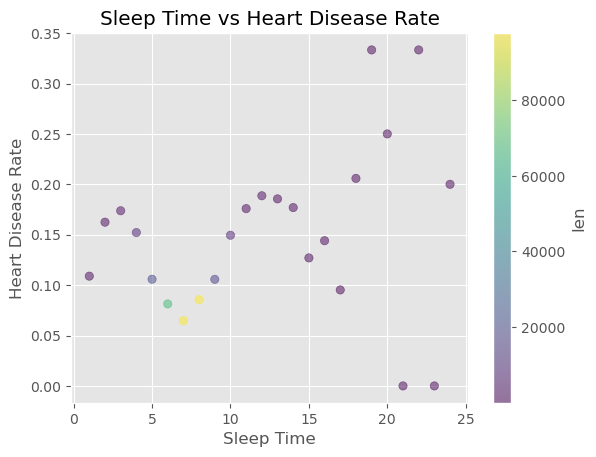

In [1265]:
sleep_pivot = df.pivot_table(
    index = ["Sleep_orig"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

fig, ax = plt.subplots()
scatter = ax.scatter(
    sleep_pivot.index, sleep_pivot[("mean", TARGET)], c = sleep_pivot[("len", TARGET)], 
    cmap = "viridis", alpha = 0.5)
ax.set_xlabel("Sleep Time")
ax.set_ylabel("Heart Disease Rate")
ax.set_title("Sleep Time vs Heart Disease Rate")
cbar = fig.colorbar(scatter)
cbar.set_label("len")
plt.show()

In [1233]:
df = df.rename(columns = { "SleepTime": "Sleep_orig" })

## Creating and applying a cardinality vs mean score
CMT_maker("Sleep_orig")

df.pivot_table(
    index = ["Sleep_orig_CMT"],
    values = TARGET, aggfunc = [len, sum, np.mean]).sort_index(ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Sleep_orig_CMT,,,
8.721,7750,1180,0.152258
8.715,7796,1165,0.149436
8.681,19184,2030,0.105817
8.661,16041,1696,0.105729
8.631,2205,416,0.188662
8.615,1992,347,0.174197
8.578,788,128,0.162437
8.571,415,73,0.175904


In [1234]:
## Creating and applying score, based on "healthy" and "unhealthy" hours.
df["Sleep_cat"] = df["Sleep_orig"].apply(lambda x: 1.5 if x in [1.0, 2.0, 3.0, 4.0, 10.0] else 1 if x in [5.0, 9.0] else 0.82 if x in [6.0, 8.0] else 0.65 if x in [7.0] else 1.8)

df.pivot_table(
    index = ["Sleep_cat"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Sleep_cat,,,
1.80,3619,657,0.181542
1.50,18877,2880,0.152567
1.00,35225,3726,0.105777
0.82,164323,13785,0.083890
0.65,97751,6325,0.064705


In [1235]:
## Logarithmic transformation
df["Sleep_LN"] = df["Sleep_orig"].apply(lambda x: np.log1p(x))

pivot_df = df.pivot_table(
    index = ["Sleep_LN"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_index(ascending=False)
pivot_df[pivot_df["len", TARGET] > 105]

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Sleep_LN,,,
2.833213,236,34,0.144068
2.772589,189,24,0.126984
2.708050,243,43,0.176955
2.564949,2205,416,0.188662
2.484907,415,73,0.175904
2.397895,7796,1165,0.149436
2.302585,16041,1696,0.105729
2.197225,97602,8358,0.085633


In [1236]:
df[["Sleep_orig", "Sleep_orig_CMT", "Sleep_cat", "Sleep_LN", TARGET]].corr().style.background_gradient(axis = None)

,Sleep_orig,Sleep_orig_CMT,Sleep_cat,Sleep_LN,HeartDisease
Sleep_orig,1.000000,0.077573,0.088623,0.970405,0.008327
Sleep_orig_CMT,0.077573,1.000000,0.663585,0.000183,0.058877
Sleep_cat,0.088623,0.663585,1.000000,-0.085936,0.083562
Sleep_LN,0.970405,0.000183,-0.085936,1.000000,-0.005748
HeartDisease,0.008327,0.058877,0.083562,-0.005748,1.000000


<br>
<H5 style="text-align: center;">Race</H5>
<p>The "Race" feature indicates the patient's ethnicity. The majority of patients in our dataset are white. <br>
<br>

To analyze this feature, we will use three strategies:<br>
- A cardinality and mean transformation<br>
- A binary numerical transformation (is white, is not white)<br>
- Categorizing via a mean to target-based score for ethnicity groups.<br>
<br>

<u>Conclusion</u>: 
The correlation to the target does not appear to be very high for this feature, but we can see that some groups, such as "Hispanic" and "Asian," seem to have a much lower rate of Heart Disease than white or black patients.</p>

In [1237]:
df.pivot_table(
    index = ["Race"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Race,,,
American Indian/Alaskan Native,5202,542,0.104191
White,245212,22507,0.091786
Other,10928,886,0.081076
Black,22939,1729,0.075374
Hispanic,27446,1443,0.052576
Asian,8068,266,0.032970


In [1238]:
## Creating and applying a cardinality vs mean score
CMT_maker("Race")

df.pivot_table(
    index = ["Race_CMT"], values = TARGET, 
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Race_CMT,,,
8.590,5202,542,0.104191
9.034,245212,22507,0.091786
8.544,10928,886,0.081076
8.486,22939,1729,0.075374
8.276,27446,1443,0.052576
8.427,8068,266,0.032970


In [1239]:
## Creating bineary categories, based on selected threshold ranges.
df["Race_cat"] = df["Race"].apply(lambda x: 4 if x in ["Asian", "Hispanic"] else 10 if x in ["American Indian/Alaskan Native", "White"] else 8)

df.pivot_table(
    index = ["Race_cat"], values = TARGET, 
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Race_cat,,,
10,250414,23049,0.092044
8,33867,2615,0.077214
4,35514,1709,0.048122


In [1240]:
df["Race"] = df["Race"].map(lambda x: 1 if x == "White" else 0)
df = df.rename(columns = {"Race": "Race_white"})

In [1241]:
df[["Race_white", "Race_cat", "Race_CMT", TARGET]].corr().style.background_gradient(axis = None)

,Race_white,Race_cat,Race_CMT,HeartDisease
Race_white,1.000000,0.833362,0.977988,0.040121
Race_cat,0.833362,1.000000,0.920109,0.050034
Race_CMT,0.977988,0.920109,1.000000,0.044253
HeartDisease,0.040121,0.050034,0.044253,1.000000


<br>
<H5 style="text-align: center;">GenHealth</H5>
<p>The "GenHealth" feature categorizes the patient's general perception of their health in 5 classes, from poor to excellent.<br>
<br>
To analyze this feature, we will use a cardinality and mean transformation, as well as creating a mean-based score.<br>
<br>
<u>Conclusion</u>: <br>
This feature appears to have a high correlation with the target, which makes sense, as if a patient feels physically unwell, the chances for all diseases may be increased, including Heart diseases.<br>
</p>

In [1242]:
df.pivot_table(
    index = ["GenHealth"], values = TARGET, 
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
GenHealth,,,
Poor,11289,3850,0.341040
Fair,34677,7084,0.204285
Good,93129,9558,0.102632
Very good,113858,5381,0.047261
Excellent,66842,1500,0.022441


In [1243]:
## Creating and applying a cardinality vs mean score
CMT_maker("GenHealth")

df.pivot_table(
    index = ["GenHealth_CMT"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
GenHealth_CMT,,,
9.461,11289,3850,0.341040
9.847,34677,7084,0.204285
9.056,93129,9558,0.102632
7.195,113858,5381,0.047261
7.240,66842,1500,0.022441


In [1244]:
df = df.rename(columns = {"GenHealth": "GenCon_cat"})
genhealth_dict = {"Poor": 3.4, "Fair": 2, "Good": 1, "Very good": 0.5, "Excellent": 0.2}
df["GenCon_cat"] = df["GenCon_cat"].map(genhealth_dict)

df.pivot_table(
    index = ["GenCon_cat"],
    values = TARGET,
    aggfunc = [len, sum, np.mean]
).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
GenCon_cat,,,
3.4,11289,3850,0.341040
2.0,34677,7084,0.204285
1.0,93129,9558,0.102632
0.5,113858,5381,0.047261
0.2,66842,1500,0.022441


In [1245]:
df[["GenCon_cat", "GenHealth_CMT", TARGET]].corr().style.background_gradient(axis = None)

,GenCon_cat,GenHealth_CMT,HeartDisease
GenCon_cat,1.000000,0.812519,0.259390
GenHealth_CMT,0.812519,1.000000,0.214578
HeartDisease,0.259390,0.214578,1.000000


<br>
<H5 style="text-align: center;">AgeCategory</H5>
<p>The "AgeCategory" feature groups patients into different age groups. This feature may be the most relevant and powerful in our dataset, as the older the patient, the higher the chance for a heart disease. This is evident in the dataset, as seen through mean to target values and general feature correlation with the target.<br>
<br>
To highlight the importance of higher age in relation to the heart disease rate, we will make some transformation efforts:<br>
<br>

- We will perform a cardinality and mean to target correlation transformation.<br>
- We will convert the strings into numerical values by taking the mean of each group, creating a weighted numerical order.<br>
- We will further summarize the categories into the 5 most significant groups and apply the mean to target as weight.<br>
<br>

All three variations show a strong correlation to the target. We will have to test later on which variation works best and will stay in the dataframe.<br>
<br>
<u>Conclusion</u>: 
As a patient ages, the likelihood of developing heart disease increases. This trend is clearly demonstrated in our data.
</p>

In [1246]:
print(df[df["AgeCategory"] == "0"][TARGET].mean())
df["AgeCategory"].value_counts()

0.0847457627118644


65-69          34143
60-64          33680
70-74          31060
55-59          29753
50-54          25378
80 or older    24150
45-49          21787
75-79          21478
18-24          21062
40-44          20999
35-39          20545
30-34          18746
25-29          16955
0                 59
Name: AgeCategory, dtype: int64

In [1247]:
## We will drop zero values, as the amount is insignificant 
df.drop(df[df["AgeCategory"] == "0"].index, inplace = True)

In [1248]:
df = df.rename(columns = {"AgeCategory": "Age"})
CMT_maker("Age")

pivot_age = df.pivot_table(
    index = ["Age_CMT"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)
pivot_age[pivot_age["len", TARGET] > 1000]

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Age_CMT,,,
9.617,24150,5448,0.225590
9.251,21478,4048,0.188472
9.244,31060,4846,0.156021
8.928,34143,4100,0.120083
8.698,33680,3326,0.098753
8.452,29753,2202,0.074009
8.313,25378,1383,0.054496
8.209,21787,744,0.034149


In [1249]:
age_dict = { "18-24": 2.1, "25-29": 2.7, "30-34": 3.2, "35-39": 3.7, "40-44": 4.2, "45-49": 4.7, "50-54": 5.2, "55-59": 5.7, "60-64": 6.2, "65-69": 6.7, "70-74": 7.2, "75-79": 7.7, "80 or older": 9.0 }
df["Age_orig"] = df["Age"].map(age_dict)

pivot_df = df.pivot_table(
    index = ["Age_orig"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)
pivot_df[pivot_df["len", TARGET] > 1000]

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Age_orig,,,
9.0,24150,5448,0.225590
7.7,21478,4048,0.188472
7.2,31060,4846,0.156021
6.7,34143,4100,0.120083
6.2,33680,3326,0.098753
5.7,29753,2202,0.074009
5.2,25378,1383,0.054496
4.7,21787,744,0.034149


In [1250]:
age_cat_dict = {1: (0, 4), 5: (4.1, 6), 10: (6.1, 7), 16: (7.1, 8), 22: (8.1, 200)}
df["Age_cat"] = df["Age_orig"].apply(
    lambda x: next((cat for cat, range in age_cat_dict.items() 
        if range[0] <= x <= range[1])))

df.pivot_table(
    index = ["Age_cat"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
Age_cat,,,
22,24150,5448,0.225590
16,52538,8894,0.169287
10,67823,7426,0.109491
5,97917,4815,0.049174
1,77308,785,0.010154


In [1251]:
df.drop("Age", axis = 1, inplace = True)
df[["Age_orig", "Age_CMT", "Age_cat", TARGET]].corr().style.background_gradient(axis = None)

,Age_orig,Age_CMT,Age_cat,HeartDisease
Age_orig,1.000000,0.943796,0.941861,0.236279
Age_CMT,0.943796,1.000000,0.978731,0.243509
Age_cat,0.941861,0.978731,1.000000,0.240436
HeartDisease,0.236279,0.243509,0.240436,1.000000


<br>
<H5 style="text-align: center;">State</H5>
<p>After analyzing the "State" feature, it appears that it does not provide any significant value. The cardinality, distribution, and mean to target are almost the same for all states, and the overall correlation with the target is very low. <br>
As a result, we have decided to remove this feature from our dataset.
</p>

In [1252]:
df.pivot_table(
    index = ["State"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
State,,,
TN,6353,591,0.093027
MA,6279,583,0.092849
OK,6304,570,0.090419
CO,6256,563,0.089994
LA,6222,556,0.089360
CA,6379,570,0.089356
WY,6135,548,0.089324
WA,6321,564,0.089226


In [1253]:
df.drop("State", inplace = True, axis = 1)

<br><br><br>
<H3 style="text-align: center;">Feature Engineering</H3>
<p>We have made various attempts to combine and manipulate features to gain further insight into the data. However, after much experimentation, we have identified a single successful and meaningful feature that we have created. This feature is called "xScore" and it is a composite score that sums up a calculated score from each feature. The calculated score is based on the respective mean of the target variable for each unique value of the feature, and it is summed up for each row in the dataframe.<br>
<br>
In a way, we can consider this "xScore" as a mini-model, as it clearly indicates that the higher the score, the higher the likelihood of a patient having a heart disease.</p>

In [1254]:
df["xScore"] = 0
feature_list = ["Stroke", "Smoking", "SkinCancer", "Race_cat", "NoPhysActivity", "MenCon_bin", "KidneyDisease", "IsMale", "DiffWalking", "Diab_No", "Diab_Yes", "Diab_RiskHigh", "Asthma", "Age_cat", "Sleep_cat", "PhysCon_orig", "GenCon_cat"]

for feature in feature_list:
    for unique_value in df[feature].unique():
        df.loc[df[feature] == unique_value, "xScore"] += round(df[df[feature] == unique_value][TARGET].mean(), 1)

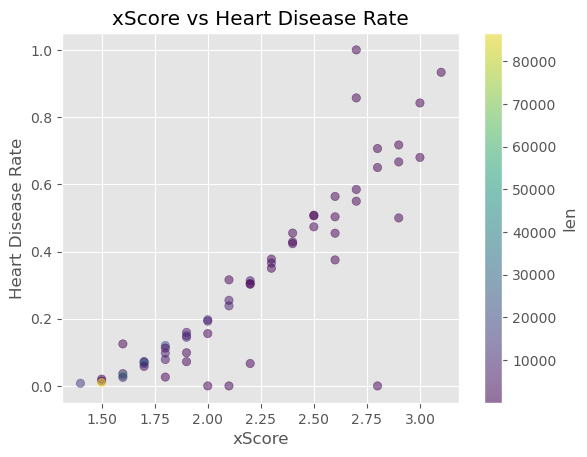

In [1269]:
feature_vs_target_w_lengh("xScore")

In [1255]:
pivot_df = df.pivot_table(
    index = ["xScore"], values = TARGET,
    aggfunc = [len, sum, np.mean]).sort_values(by = [("mean", TARGET)], ascending = False)
pivot_df[pivot_df["len", TARGET] > 100]

,len,sum,mean
,HeartDisease,HeartDisease,HeartDisease
xScore,,,
2.8,184,130,0.706522
2.7,313,183,0.584665
2.6,477,269,0.563941
2.7,251,138,0.549801
2.5,720,366,0.508333
2.5,164,83,0.506098
2.6,596,300,0.503356
2.5,999,473,0.473473


In [1256]:
# Sort the columns alphabetically
df = df.sort_index(axis = 1)
col_to_move = "HeartDisease"
cols = df.columns.tolist()
cols.remove(col_to_move)
cols.insert(0, col_to_move)
df = df.reindex(columns=cols)

In [1257]:
df.head(7).T

,0,1,2,3,4,5,6
HeartDisease,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Age_CMT,8.452000,9.617000,8.928000,9.251000,8.149000,9.251000,9.244000
Age_cat,5.000000,22.000000,10.000000,16.000000,5.000000,16.000000,16.000000
Age_orig,5.700000,9.000000,6.700000,7.700000,4.200000,7.700000,7.200000
Asthma,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
BMI_LN,2.867899,3.060583,3.317091,3.227241,3.207208,3.396855,3.119276
BMI_grped,7.500000,5.900000,8.000000,7.000000,7.000000,9.500000,5.900000
BMI_orig,16.600000,20.340000,26.580000,24.210000,23.710000,28.870000,21.630000
Diab_No,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
Diab_RiskHigh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<H3 style="text-align: center;">Feature Selection</H3>
<p></p>

In [952]:
df.corr()[0:1].T.style.background_gradient(axis = None)

,HeartDisease
HeartDisease,1.000000
AgeCategory_CMT,0.243509
Age_CMT,0.243509
Age_cat,0.240436
Age_orig,0.236279
Asthma,0.041421
BMI_LN,0.053923
BMI_grped,0.052983
BMI_orig,0.051729
Diab_No,-0.170966


<br><br>

<H3 style="text-align: center;">Feature Selection</H3>

<p>We have carefully evaluated and selected a set of features to predict heart disease by conducting a series of experiments. The selected features are:<br>
<br>
<b>xScore, Age_cat, IsMale, GenCon_cat, Diab_Yes, and Stroke</b>. <br>
<br>
The "xScore" feature, which is a composite score incorporating values and weights from all original features, serves as a strong predictor on its own. <br>
However, by incorporating those additional features that have a strong correlation with the target, we aim to provide the model with more flexibility and robustness in its decision-making process. The model can use these features as additional weight or filters to improve the overall prediction results.<br>
<br>
In order to select the additional 4 features, we conducted a series of experiments without going into too much detail. We decided to permanently incorporate the "xScore" feature as a strong predictor on its own. To evaluate the other features, we tried various techniques such as:<br>
<br>

- Testing all possible combinations of minimum 3 and maximum all (unique type) features using a basic decision tree model with default parameters. We did not combine variations (as _orig, _bin, _LN, _CMT) of each feature in these combinations.<br>

- Evaluating the correlation of all 2, 3, 4 and 5 pair combinations of unique type features with the target.<br>

- Utilizing experimental functions to evaluate feature importance.<br>

- Hand selecting features based on domain knowledge research<br>
<br>

Our goal was to optimize the model's performance by selecting the best combination of features, and we believe that the final selection of features will lead to the best results.</p>

In [ ]:
### Experimental Auto Feature Selection - worked okay'ish
results = get_best_features(df, TARGET, 3, 15, 0.05, 0.35)

Stroke            128
Age_cat            71
KidneyDisease      54
DiffWalking        51
IsMale             41
Smoking            37
Diab_Yes           36
Race_white         32
NoPhysActivity     31
BMI_grped          29
PhysCon_bin        28
xScore             23
MenCon_bin         21
Sleep_cat          16
dtype: int64
['Stroke', 'Age_cat', 'KidneyDisease', 'DiffWalking', 'IsMale', 'Smoking', 'Diab_Yes', 'Race_white', 'NoPhysActivity', 'BMI_grped', 'PhysCon_bin', 'xScore', 'MenCon_bin', 'Sleep_cat', 'HeartDisease']


In [ ]:
final_df = df[[TARGET, "xScore", "Age_cat", "IsMale", "GenCon_cat", "Diab_Yes", "Stroke"]]
df.to_csv("final_variations_df.csv")
final_df.to_csv("final_model_df.csv")

In [ ]:
final_df.corr().style.background_gradient(axis = None)

,HeartDisease,xScore,Age_cat,IsMale,GenCon_cat,Diab_Yes,Stroke
HeartDisease,1.000000,0.361879,0.240436,0.070013,0.259377,0.183062,0.196880
xScore,0.361879,1.000000,0.591690,-0.041628,0.690548,0.542693,0.447686
Age_cat,0.240436,0.591690,1.000000,-0.066682,0.160316,0.185535,0.139525
IsMale,0.070013,-0.041628,-0.066682,1.000000,-0.025179,0.020751,-0.003063
GenCon_cat,0.259377,0.690548,0.160316,-0.025179,1.000000,0.274330,0.185239
Diab_Yes,0.183062,0.542693,0.185535,0.020751,0.274330,1.000000,0.108390
Stroke,0.196880,0.447686,0.139525,-0.003063,0.185239,0.108390,1.000000


<br><br>

<H3 style="text-align: center;">Model Selection</H3>

<p>After thoroughly evaluating different models, we have ultimately selected XGBoost as the best fit for our assignment. The selection process involved running a series of test dataframes through a pipeline with five different models: Decision Tree, Gaussian NB, Gradient Boosting, Logistic Regression, and XGBoost Classifier. We also conducted some basic hyperparameter optimization within the pipeline.<br>
<br>
XGBoost Classifier performed the best with the majority of our test dataframes, however, it's worth mentioning that we believe that most of the models we experimented with would have been suitable and with more optimization, we could have achieved similar results with all models. Our final decision was based on the best performance of the model in our test environment</p><br>
<br>

In [ ]:
### EXPERIMENTING WITH A FEW MODELS, before making the final decision on which model to use in the end

### TEST CONFIGS 
balance = (len(df[df[TARGET] == 1]) / len(df[df[TARGET] == 0])) * 100
model_dict = {
    "DecisionTree": {
            "model": DecisionTreeClassifier(),
            "params": {
                "random_state": [42],
                "max_depth": list(range(2, 10)),
                "splitter": ["best"],
                "min_samples_leaf": list(range(1, 30, 5)),
                "criterion": ["gini"],
                "class_weight": ["balanced"]}},
    "Gaussian NB": {
            "model": GaussianNB(),
            "params": { 
                "var_smoothing": np.logspace(0, -9, num = 100)}},
    "Gradient Boosting": {
            "model": HistGradientBoostingClassifier(),
            "params": {
                "random_state": [42],
                "max_depth": list(range(2, 10, 2)),
                "min_samples_leaf": list(range(10, 30, 5)),
                "learning_rate": [0.001, 0.005, 0.1],
                "max_iter": [350, 500],
                "class_weight": ["balanced"]
                }},
    "Logistic Regression": {
            "model": LogisticRegression(),
            "params": {
                "random_state": [42],
                "solver": ["newton-cg"],
                "C": [0.001, 0.005, 0.1],
                "max_iter": list(range(250, 450)),
                "class_weight": ["balanced"]}},
    "XGBoost Classifer": {
            "model": XGBClassifier(),
            "params": {
                "max_depth": list(range(2, 10, 2)),
                "learning_rate": [0.001, 0.005, 0.1],
                "random_state": [42],
                "colsample_bylevel": [0.1, 0.5, 1],
                "scale_pos_weight": [balance]}}}


Scorings for  DecisionTree
Train:  0.6596117329044077 0.1815930388219545 0.8522513089005236
Test:  0.6595010477372004 0.18283708230399168 0.8503870343492985
TN = 56229 - FN = 1237 - TP = 7031 - FP = 31424
AUC score: 0.8158652818508503  mean probabilities: 0.37171401804404347

Scorings for  Gaussian NB
Train:  0.8657194558005495 0.30095217328100016 0.43356020942408374
Test:  0.8645447816432272 0.3018535603455506 0.435292694726657
TN = 79329 - FN = 4669 - TP = 3599 - FP = 8324
AUC score: 0.82088493575607  mean probabilities: 0.13255209686711492

Scorings for  Gradient Boosting
Train:  0.6833456202667382 0.19077312691131498 0.8361256544502618
Test:  0.6827806215531531 0.19203402079048307 0.8356313497822931
TN = 58584 - FN = 1359 - TP = 6909 - FP = 29069
AUC score: 0.8270462908754681  mean probabilities: 0.400515328379087

Scorings for  Logistic Regression
Train:  0.7465272658222193 0.2175655593749531 0.758848167539267
Test:  0.7467916306126917 0.21884871884871884 0.7541122399612966
TN = 

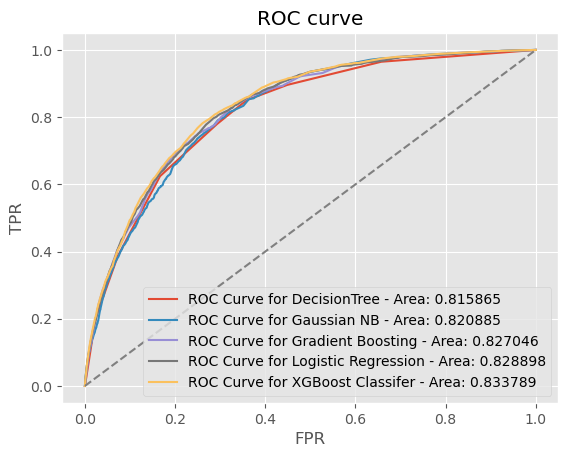

In [ ]:
train, test, stored_models = master_modeller(final_df, TARGET, model_dict)

<br><br>

<H3 style="text-align: center;">Modelling</H3>

<br><H5 style="text-align: center;">Data partitions</H5>

<p>To ensure accurate and reliable results, we divided our data into three distinct parts: training, testing, and validation. We selected a 60/20/20 distribution for these sets, keeping in mind that we have also experimented with other distribution settings. Although we found that these alternative distributions also yielded similar results, we ultimately decided to use the one with the smallest possible training data. This decision was based on the belief that a model trained on a smaller data set is more trustworthy and generalizable to unseen data ultimately.</p><br>

In [ ]:
X = final_df.drop([TARGET], axis = 1)
y = final_df[TARGET]

train, test, target, target_test = train_test_split(
    X, y, test_size = 0.2)

train, val, target, target_val = train_test_split(
    train, target, test_size = 0.25)

balance = (len(df[df[TARGET] == 1]) / len(df[df[TARGET] == 0])) * 100

split_data_dict = {
    "TRAINING": [train, target],
    "TESTING": [test, target_test],
    "VALIDATION": [val, target_val]}

print("Train:", train.shape, "| Target Mean:", target.mean())
print("Test:", test.shape, "| Target Mean:", target_test.mean())
print("Validation:", val.shape, "| Target Mean:", target_val.mean())

Train: (191841, 6) | Target Mean: 0.08563341517193926
Test: (63948, 6) | Target Mean: 0.08536623506599111
Validation: (63947, 6) | Target Mean: 0.08571160492282671


<br>
<H4 style="text-align: center;">Goal</H4>

<p>Deciding on the goal of our model was a tricky task. We had to weigh different options and think about what would be the best approach for our specific problem. After considering all factors, we ultimately decided to optimize our model for accuracy in positive predictions. Our main focus was to get as many true positives as possible and as few false negatives as possible.<br>
<br>
The reason behind this choice is that the model will be used in a medical setting to make recommendations to patients. And in situations like these, getting a wrong diagnosis can have serious consequences. So, it's crucial that we're as confident as possible when saying a patient does not have a disease. It's not ideal for a patient who doesn't have a disease to go through additional tests, but it's still better than saying a patient is healthy when they're not.<br>
<br>
In short, we want our model to be accurate in identifying patients who do have a disease, while minimizing the chances of falsely identifying patients as healthy. This approach is all about protecting patients from any negative consequences that can come from a wrong diagnosis.</p><br>

<H5 style="text-align: center;">Model Parameters</H5>

<p>Throughout our experimentation, we explored a variety of parameter settings to optimize the performance of our model. However, we found that the best results were achieved with a relatively simple set of parameters. One key factor that greatly improved our results was setting the 'scale_pos_weight' parameter to match the distribution of the target. This enabled the model to effectively identify patterns within the dataset and resulted in a significant improvement in the quality of our results.<br>
<br>
We also made use of the built-in cross-validation function in XGBoost, running it for 50 iterations. This helped us make sure that the model's performance wasn't just based on a lucky initial sample, but on multiple different samples. This approach increases the robustness and the reliability of the results.
</p><br>

In [ ]:
XGB_model = XGBClassifier(
    max_depth = 4,
    random_state = RANDOM_STATE,
    learning_rate = 0.002,
    colsample_bylevel = 0.5,
    scale_pos_weight = balance,
    verbosity = 0,
    n_jobs = -1)

XGB_model.fit(train, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.002, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=55, ...)

<br><br><br>
<H3 style="text-align: center;">### R E S U L T S ###</H3>
<br>

______________________ SCORES & EVALUATIONS _______________________________

###################### TRAINING ###########################################
Accuracy: 0.72268 | Precision: 0.20928 | Recall: 0.8057 | F1_Score: 0.33225
TN = 125403 | FN = 3192 | TP = 13236 | FP = 50010
Positive prediction value: 20.93% | Negative prediction value: 97.52%

###################### TESTING ############################################
Accuracy: 0.72282 | Precision: 0.2095 | Recall: 0.81022 | F1_Score: 0.33292
TN = 41800 | FN = 1036 | TP = 4423 | FP = 16689
Positive prediction value: 20.95% | Negative prediction value: 97.58%

###################### VALIDATION #########################################
Accuracy: 0.72003 | Precision: 0.20725 | Recall: 0.80223 | F1_Score: 0.3294
TN = 41647 | FN = 1084 | TP = 4397 | FP = 16819
Positive prediction value: 20.72% | Negative prediction value: 97.46%

###################### CROSS-VALIDATION ###################################
   train-auc-mean  train-auc-std

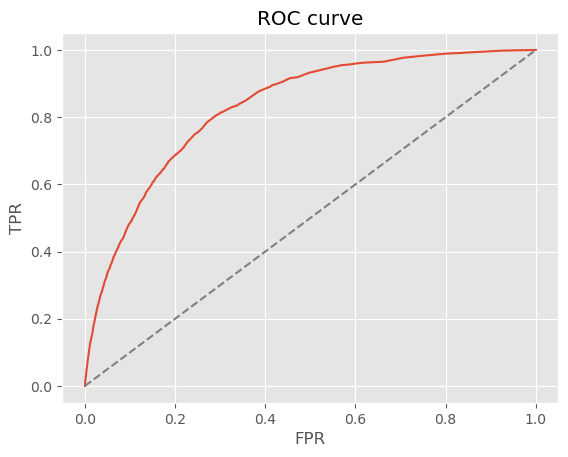

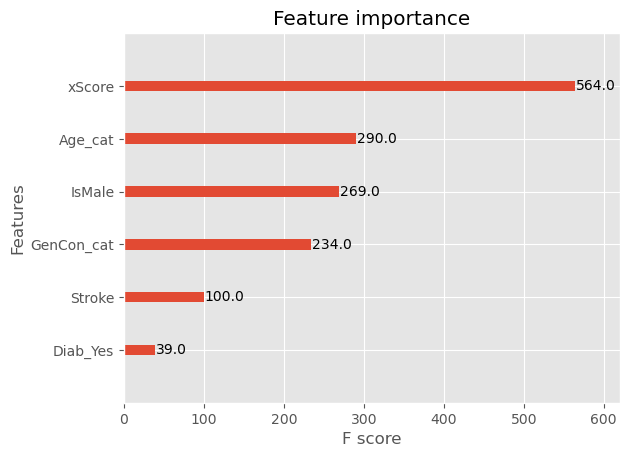

In [ ]:
#print_formatted_word("SCORES & EVALUATIONS")
print("______________________ SCORES & EVALUATIONS _______________________________\n")

for data in split_data_dict.items():

    pred = XGB_model.predict(data[1][0])
    confusion_matrix = metrics.confusion_matrix(data[1][1], pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Accuracy = metrics.accuracy_score(data[1][1], pred)
    Precision = metrics.precision_score(data[1][1], pred)
    Recall = metrics.recall_score(data[1][1], pred)
    F_1_Score = metrics.f1_score(data[1][1], pred)

    probs = XGB_model.predict_proba(data[1][0])[:, 1]
    probs_mean = round(probs.mean()* 100, 2) 
    auc_score = roc_auc_score(data[1][1], probs)
    fpr, tpr, thresholds = roc_curve(data[1][1], probs)

    PPV, NPV = ((tp / (tp + fp)) * 100), ((tn / (fn + tn)) * 100)
    
    
    print_formatted_word(data[0])
    print(f"Accuracy: {round(Accuracy, 5)} | Precision: {round(Precision, 5)} | Recall: {round(Recall, 5)} | F1_Score: {round(F_1_Score, 5)}")
    print(f"TN = {tn} | FN = {fn} | TP = {tp} | FP = {fp}")
    print(f"Positive prediction value: {round(PPV, 2)}% | Negative prediction value: {round(NPV, 2)}%\n")

data_dmatrix = xgb.DMatrix(X, y)
xgb_cv = cv(
    dtrain = data_dmatrix, 
    params = XGB_model.get_params(), 
    nfold = 3,
    num_boost_round = 50, 
    early_stopping_rounds = 10, 
    metrics = "auc", 
    as_pandas = True, 
    seed = RANDOM_STATE)

print_formatted_word("CROSS-VALIDATION")
  
print(xgb_cv.head())

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--")
plt.xlabel("FPR") 
plt.ylabel("TPR")
plt.title("ROC curve")
plt.show()

xgb.plot_importance(XGB_model)
plt.show()

<br><br>

<H3 style="text-align: center;">Interpreting results</H3>

<p>We are satisfied with the results we have achieved with our model. 
We were able to keep false negatives as low as possible while still achieving a decent number of true positives. In numbers this means that if the model predicts that a patient has heart disease, there is a <b>20.7%</b> chance that the patient actually does have heart disease. On the other hand, if the model predicts that a patient does not have heart disease, we can be <b>97.5%</b> sure that the prediction is correct.<br>
<br>
Although the overall prediction rate is around 50%, we believe the model still works well and could have real-world application. Given the importance of accurate predictions in medical scenarios, we believe that the model's ability to minimize false negatives outweighs the slightly lower overall prediction rate.</p>

<H5 style="text-align: center;">Final words</H5>

<p>It is important to note that this model is not intended to initiate medical treatment. Its purpose is to identify patients who have an increased risk of having heart disease based on their lifestyle and the information available. If our model predicts a positive result, it is recommended that a thorough medical examination and professional assessment be conducted before any treatment is prescribed. This model is meant to serve as a tool for healthcare professionals to make informed decisions and prioritize patients who may be at higher risk for heart disease.</p>

<br><br><br><br><br><br>

<H5 style="text-align: center;">Shap Model Explainer</H5>

100%|===================| 63905/63948 [02:03<00:00]        

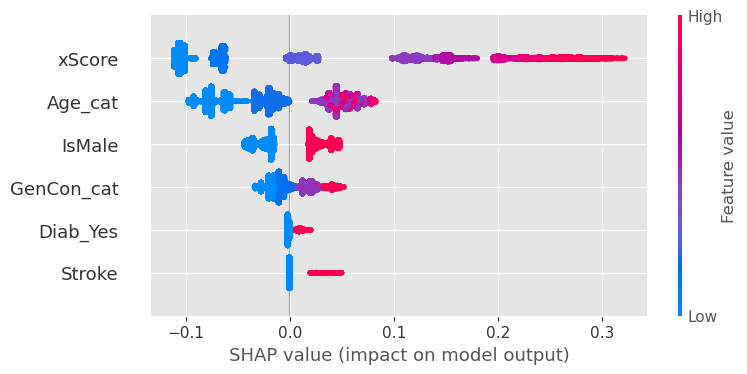

In [ ]:
shap.initjs() 
explainer = shap.Explainer(XGB_model, train) 
shap_values = explainer(test) 
shap.plots.beeswarm(shap_values)

        HeartDisease  xScore  Age_cat  IsMale  GenCon_cat  Diab_Yes  Stroke
136612             0     1.5        5       1         0.5         0       0


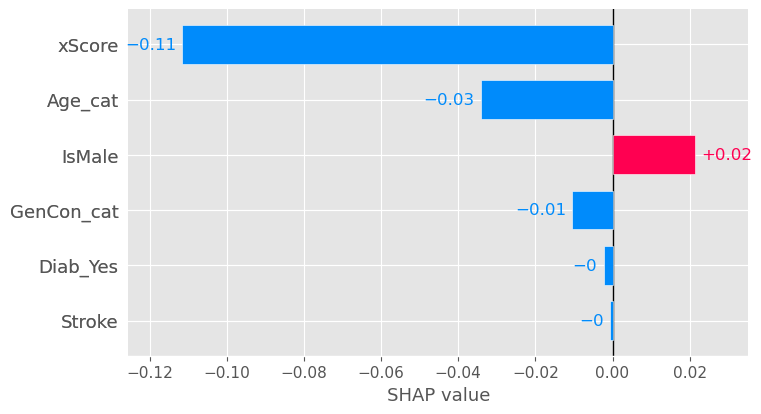

        HeartDisease  xScore  Age_cat  IsMale  GenCon_cat  Diab_Yes  Stroke
224724             1     1.7       10       0         1.0         0       0


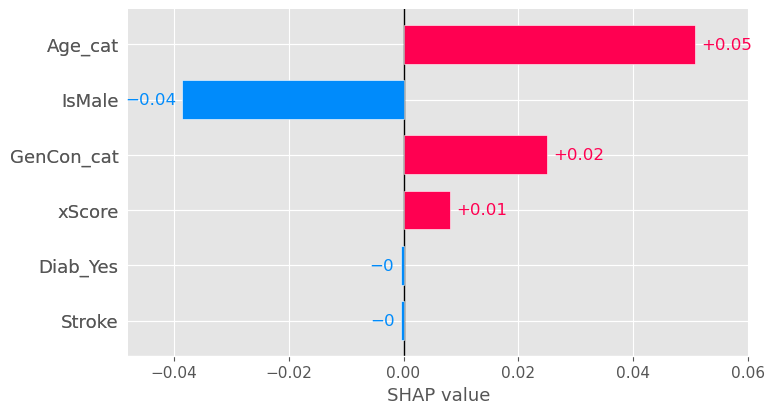

In [ ]:
print(pd.concat([target_test.iloc[6:7], test.iloc[6:7]], axis = 1))
shap.plots.bar(shap_values[6])

print(pd.concat([target_test.iloc[23:24], test.iloc[23:24]], axis = 1))
shap.plots.bar(shap_values[23])